# Autotalker Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 23.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [4]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_rep1"
batch2 = "embryo1_rep2"
batch3 = "embryo2_rep1"
batch4 = "embryo2_rep2"
batch5 = "embryo3_rep1"
batch6 = "embryo3_rep2"
n_neighbors = 4

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"

# Trainer
n_epochs = 20
n_epochs_all_gps = 10
lr = 0.001

## Others
random_seed = 42

### 1.3 Run Notebook Setup

In [5]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [6]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [7]:
# Define paths
figure_folder_path = f"../figures/{dataset}/analysis/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/analysis/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [8]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch1}.h5ad")

In [9]:
# Compute (separate) spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)
# Make adjacency matrix symmetric
adata.obsp["spatial_connectivities"] = adata.obsp["spatial_connectivities"].maximum(
    adata.obsp["spatial_connectivities"].T)

### 2.2 Explore Data

Using dataset seqfish_mouse_organogenesis_embryo1_rep1.
Number of nodes (cells): 10150
Number of node features (genes): 351


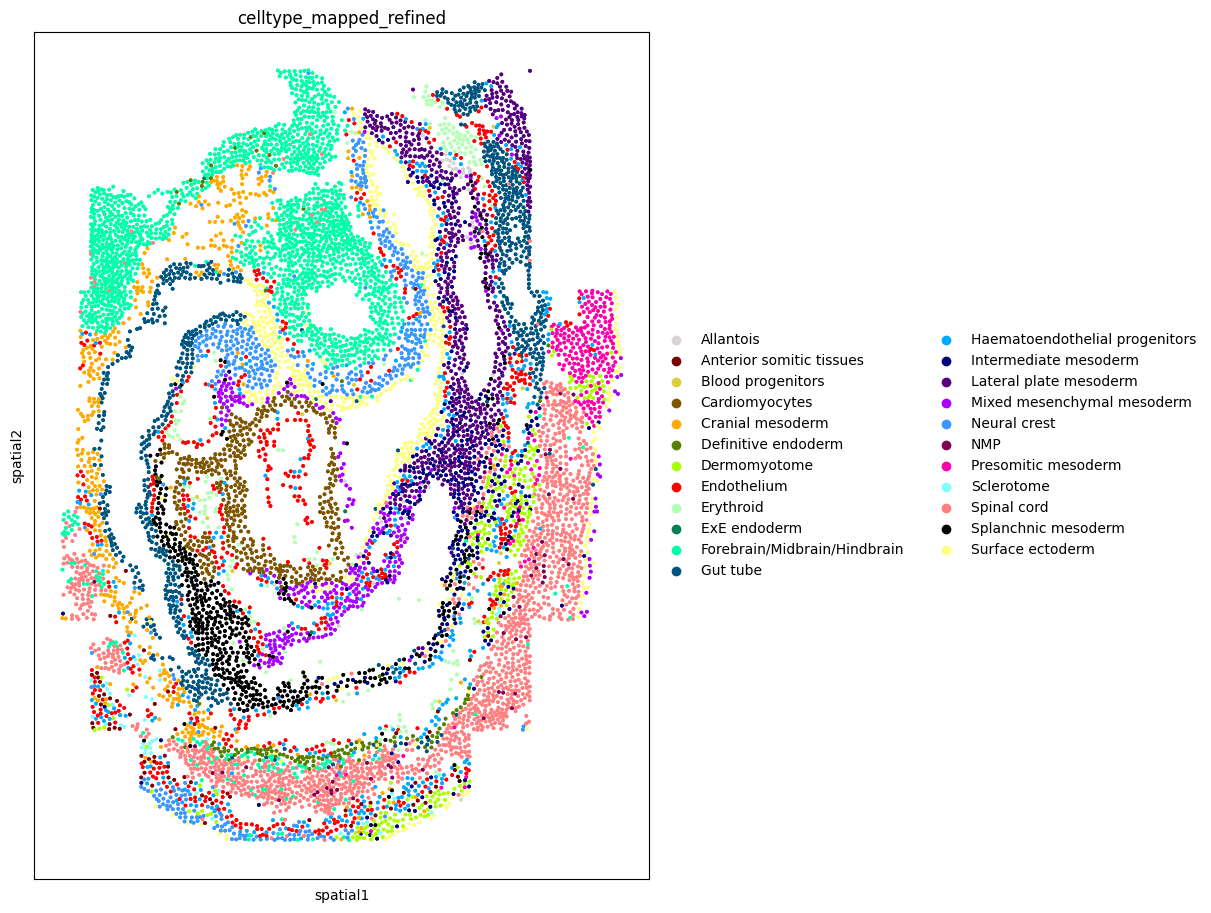

In [10]:
print(f"Using dataset {dataset}_{batch1}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in spatial space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

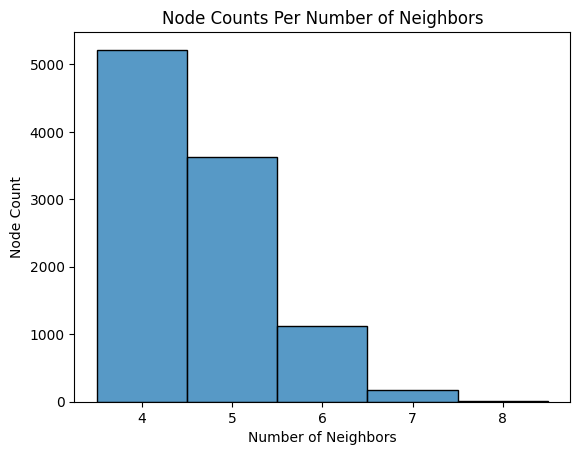

Average number of edges per node: 4.63.
Number of total edges: 23510.


In [11]:
# Plot histogram of node counts per number of neighbors
ax = sns.histplot(np.squeeze(np.asarray(adata.obsp['spatial_connectivities'].sum(axis=0))),
                  discrete=True)
ax.set_title("Node Counts Per Number of Neighbors")
ax.set_ylabel("Node Count")
ax.set_xlabel("Number of Neighbors")
fig = ax.figure
fig.savefig(f"{figure_folder_path}/node_counts_per_n_neighs.png",
            bbox_inches="tight")
plt.show()

avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
print(f"Average number of edges per node: {avg_edges_per_node}.")
n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
print(f"Number of total edges: {n_edges}.")

## 3. Autotalker Model with Prior Knowledge Cell-Cell-Interaction (CCI) Gene Programs (GPs)

### 3.1 Prepare Prior Knowledge CCI GP Mask

In [12]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [13]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [14]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [15]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [16]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [17]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key="autotalker_gp_targets",
    gp_sources_mask_key="autotalker_gp_sources",
    gp_names_key="autotalker_gp_names",
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns["autotalker_gp_names"])

In [18]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 489.
Example gene programs: ['GDF2_ligand_targetgenes_GP', 'CDHR1_ligand_targetgenes_GP', 'PSEN1_ligand_targetgenes_GP', 'GIP_ligand_targetgenes_GP', 'CRLF2_ligand_targetgenes_GP'].
Number of gene program target genes: 7476.
Number of gene program source genes: 127.


### 3.2 Initialize, Train & Save Model

In [258]:
# Initialize model
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=None,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


In [259]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 9135
Number of validation nodes: 1015
Number of training edges: 21159
Number of validation edges: 2351

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% val_auroc_score: 0.9062; val_auprc_score: 0.8609; val_best_acc_score: 0.8005; val_best_f1_score: 0.8314; train_kl_reg_loss: 0.0963; train_edge_recon_loss: 3.7693; train_gene_expr_recon_loss: 134.5203; train_group_lasso_reg_loss: 0.0000; train_global_loss: 138.3859; train_optim_loss: 138.3859; val_kl_reg_loss: 0.1362; val_edge_recon_loss: 3.1650; val_gene_expr_recon_loss: 127.6644; val_group_lasso_reg_loss: 0.0000; val_global_loss: 130.9656; val_optim_loss: 130.9656
Epoch 2/20 |██------------------| 10.0% val_auroc_score: 0.9141; val_auprc_score: 0.8635; val_best_acc_score: 0.8126; val_best_f1_score: 0.8411; train_kl_reg_loss: 0.1360; train_edge_recon_loss: 3.6394; train_gene_expr_recon_loss: 124.7315; train_group_lasso_reg_loss: 0.0000; train_global_loss: 128.5070; tra

In [21]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/prior_knowledge_gp_mask",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}_{batch1}.h5ad")

## 4. Analysis

### 4.1 Load Model

In [19]:
load_timestamp = "23012023_063750"

In [20]:
# Load trained model
model = Autotalker.load(dir_path=f"../artifacts/seqfish_mouse_organogenesis/analysis/{load_timestamp}/prior_knowledge_gp_mask",
                        adata=None,
                        adata_file_name=f"{dataset}_{batch1}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


In [260]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 489.
Number of active gene programs: 434.


In [261]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key, key_added=latent_key)
sc.tl.umap(model.adata, neighbors_key=latent_key)

### 4.1 Cell Types in Spatial and Physical Space

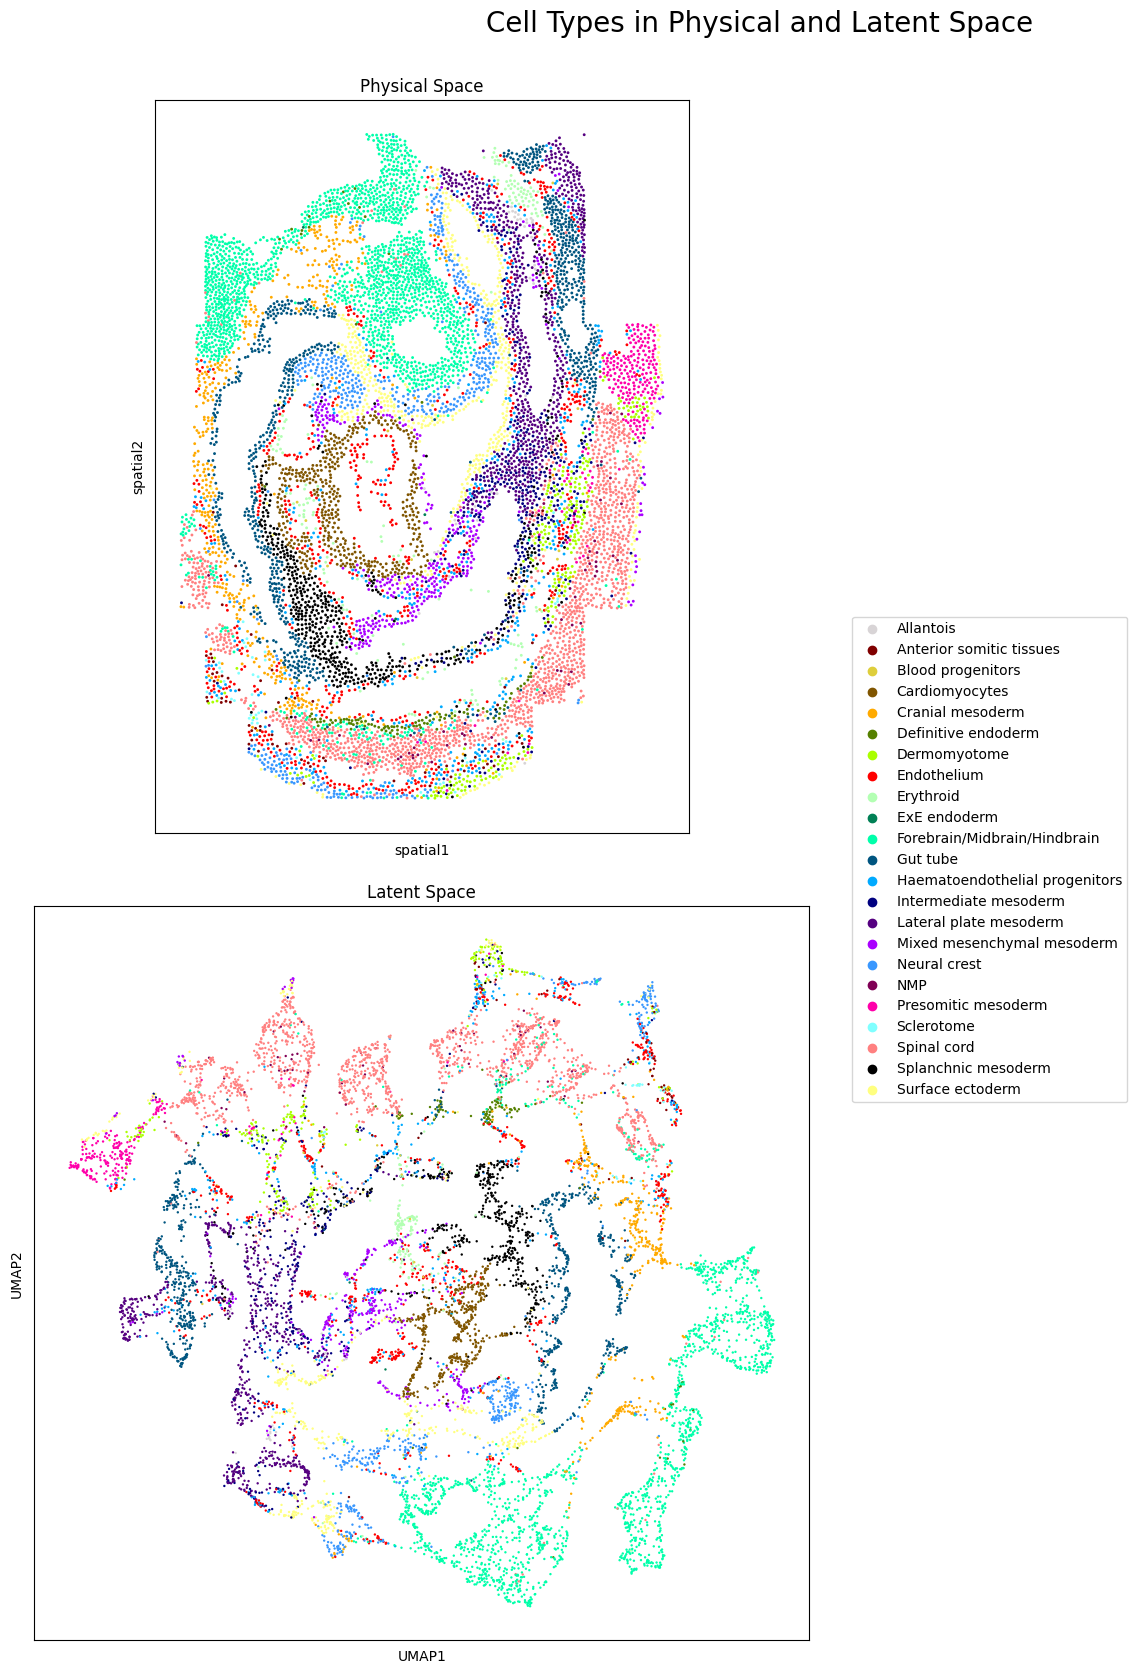

In [262]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Cell Types in Physical and Latent Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.spatial(adata=model.adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"{figure_folder_path}/cell_types_physical_latent_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 4.2 Latent Leiden Clusters in Latent and Physical Space

In [263]:
# Compute latent Leiden clustering
resolution = 0.3

sc.tl.leiden(adata=model.adata,
             resolution=resolution,
             random_state=random_seed,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=model.adata.obsp[f"{latent_key}_connectivities"])

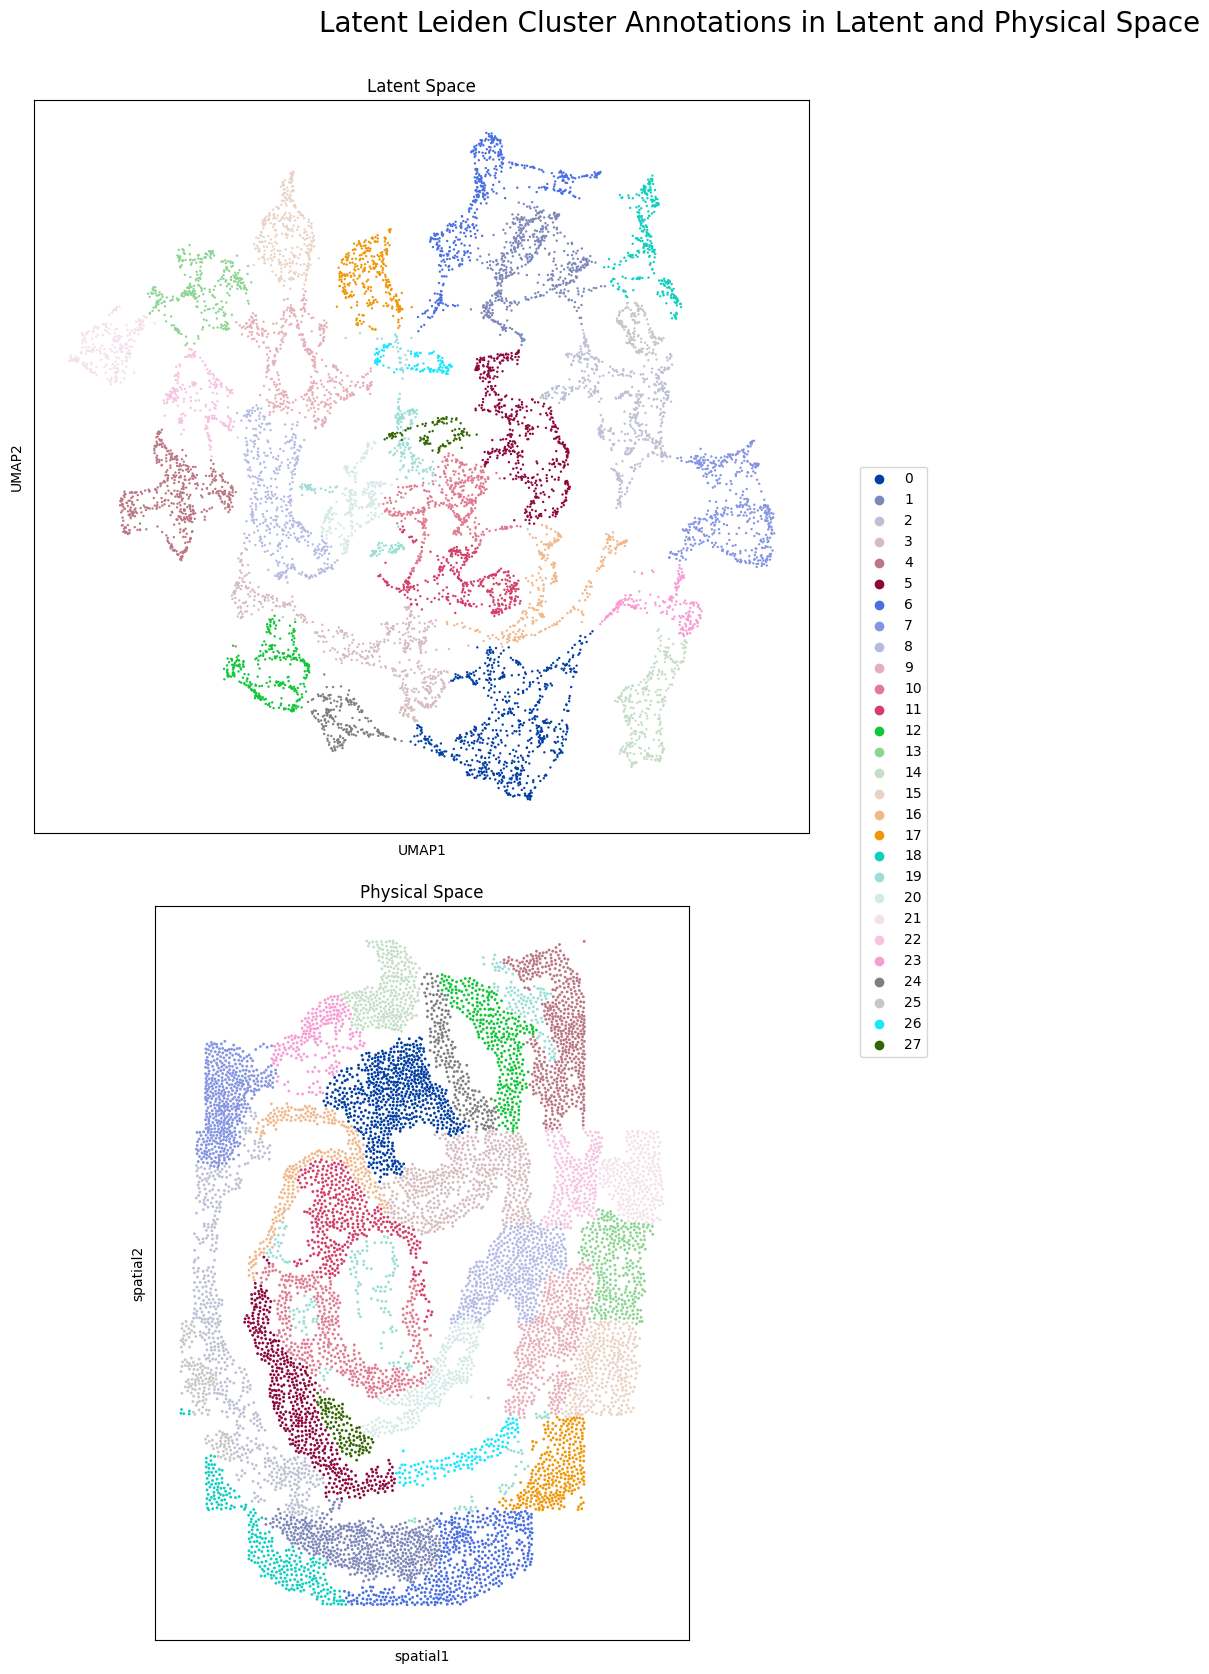

In [264]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Latent Leiden Cluster Annotations in Latent and Physical Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.umap(adata=model.adata,
           color=[f"latent_leiden_{str(resolution)}"],
           title=f"Latent Space",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=model.adata,
              color=[f"latent_leiden_{str(resolution)}"],
              spot_size=0.03,
              title=f"Physical Space",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.025, 0.7))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"{figure_folder_path}/latent_leiden_clusters_latent_physical_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 4.3 GP Enrichments

#### 4.3.1 Cell-type GP Enrichments

In [484]:
differential_gp_scores_key = "autotalker_cell_type_differential_gp_scores"
n_top_up_gps = 10
n_top_down_gps = 10

##### 4.3.1.1 Explore All GPs Across All Categories

In [485]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=10000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [486]:
gp = "BMP7_ligand_receptor_GP"
cell_type = "Cardiomyocytes"
gene = "Bmp7"

print(model.compute_gp_gene_importances(selected_gp=gp))

selected_gps_idx, selected_gps_weights = model.get_gp_data(
            selected_gps=gp,
            adata=adata)

print(f"Index: {selected_gps_idx}")

model_latent = model.get_latent_representation(only_active_gps=False)
gp_latent = model_latent[:, selected_gps_idx]

gp_latent_cell_type = gp_latent[torch.flatten(torch.tensor(adata.obs["celltype_mapped_refined"] == cell_type).nonzero())]
gp_latent_other = gp_latent[~torch.flatten(torch.tensor(adata.obs["celltype_mapped_refined"] == cell_type).nonzero())]
print(f"Cell type gp mean: {gp_latent_cell_type.mean()}")
print(f"Other gp mean: {gp_latent_other.mean()}")
gp_latent_obs = np.array(model.adata.obs[gp]).reshape(-1, 1)
gp_latent_obs_cell_type = gp_latent_obs[torch.flatten(torch.tensor(adata.obs["celltype_mapped_refined"] == cell_type).nonzero())]
gp_latent_obs_other = gp_latent_obs[~torch.flatten(torch.tensor(adata.obs["celltype_mapped_refined"] == cell_type).nonzero())]
print(f"Cell type norm gp mean: {gp_latent_obs_cell_type.mean()}")
print(f"Other norm gp mean: {gp_latent_obs_other.mean()}")

gene_cell_type = adata.X[:, adata.var_names == gene].toarray()[torch.flatten(torch.tensor(adata.obs["celltype_mapped_refined"] == cell_type).nonzero())]
gene_other = adata.X[:, adata.var_names == gene].toarray()[~torch.flatten(torch.tensor(adata.obs["celltype_mapped_refined"] == cell_type).nonzero())]
print(f"Cell type gene mean: {gene_cell_type.mean()}")
print(f"Other gene mean: {gene_other.mean()}")

    gene gene_entity  gene_weight_sign_corrected  gene_importance
0   Bmp7      source                     0.38908         0.953558
1  Acvr1      target                     0.01895         0.046442
Index: [420]
Cell type gp mean: -1.1141578918790709
Other gp mean: -0.05147142498594492
Cell type norm gp mean: 1.1141578950089952
Other norm gp mean: 0.05147142550582704
Cell type gene mean: 1.8542648553848267
Other gene mean: 0.4209948778152466


In [487]:
mask = torch.zeros(len(model.adata.uns["autotalker_gp_names"]), dtype=torch.bool)
mask.scatter_(-1, torch.tensor(model.get_gp_data(selected_gps=active_gps)[0]), 1)
model_latent[torch.flatten(torch.tensor(adata.obs["celltype_mapped_refined"] == cell_type)),:][:,mask]

array([[-0.03240157, -0.13426131, -0.08100342, ...,  0.13865864,
         0.36684221,  0.20236678],
       [ 0.12359663, -0.0478926 ,  0.05478813, ...,  0.19656326,
         0.48403913,  0.25309393],
       [ 0.06907377, -0.06202741,  0.15178633, ...,  0.21729201,
         0.47806036,  0.1939858 ],
       ...,
       [ 0.07526607,  0.05905695, -0.4773691 , ..., -0.28907126,
        -0.10271804,  0.07307208],
       [ 0.10066437, -0.03212304, -0.35125098, ...,  0.16491328,
         0.20860897, -0.05735937],
       [ 0.15322717,  0.02477065, -0.44247171, ..., -0.27840927,
        -0.21308564,  0.01405926]])

In [488]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

category                         gene_program      p_h0  \
0       Cardiomyocytes          CADM1_ligand_targetgenes_GP  0.995876   
1       Cardiomyocytes           BMP7_ligand_targetgenes_GP  0.994808   
2       Cardiomyocytes              BMP7_ligand_receptor_GP  0.990683   
3       Cardiomyocytes          CDH18_ligand_targetgenes_GP  0.986394   
4            Erythroid          CRLF1_ligand_targetgenes_GP  0.985560   
5            Erythroid  Glycine_metabolite_enzyme_sensor_GP  0.984629   
6       Cardiomyocytes           DKK2_ligand_targetgenes_GP  0.984156   
7       Cardiomyocytes         PIK3CB_ligand_targetgenes_GP  0.978764   
8  Presomitic mesoderm           CD24_ligand_targetgenes_GP  0.972642   
9  Presomitic mesoderm            MPZ_ligand_targetgenes_GP  0.972374   

       p_h1  log_bayes_factor  
0  0.004124          5.486896  
1  0.005192          5.255504  
2  0.009317          4.666581  
3  0.013606          4.283520  
4  0.014440          4.223186  
5  0.015371          4.159797  
6  0.015844          4.128984  
7  0.021236          3.830610  
8  0.027358          3.570989  
9  0.027626          3.560995

In [489]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

category                 gene_program      p_h0      p_h1  \
9981          Cardiomyocytes   IGF1_ligand_targetgenes_GP  0.002322  0.997678   
9980          Cardiomyocytes    LTF_ligand_targetgenes_GP  0.003678  0.996322   
9979          Cardiomyocytes  CDH11_ligand_targetgenes_GP  0.004115  0.995885   
9978          Cardiomyocytes  TGFB2_ligand_targetgenes_GP  0.006332  0.993668   
9977          Cardiomyocytes    EGF_ligand_targetgenes_GP  0.010818  0.989182   
9976     Presomitic mesoderm  CRLF2_ligand_targetgenes_GP  0.016383  0.983617   
9975          Cardiomyocytes   EBI3_ligand_targetgenes_GP  0.016966  0.983034   
9974               Erythroid  NLGN3_ligand_targetgenes_GP  0.029928  0.970072   
9973  Lateral plate mesoderm   TSLP_ligand_targetgenes_GP  0.041860  0.958140   
9972               Erythroid    VGF_ligand_targetgenes_GP  0.049064  0.950936   

      log_bayes_factor  
9981         -6.062788  
9980         -5.601728  
9979         -5.489041  
9978         -5.055844  
9977         -4.515629  
9976         -4.095004  
9975         -4.059452  
9974         -3.478585  
9973         -3.130664  
9972         -2.964319

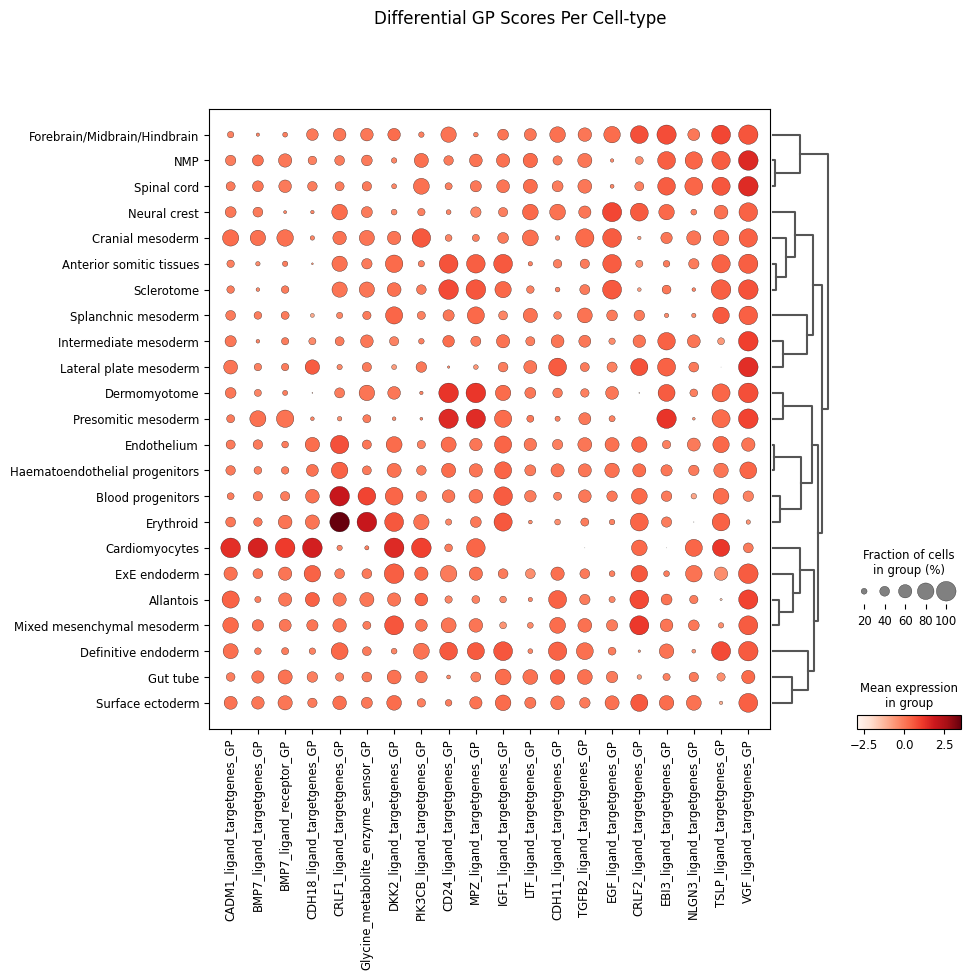

In [490]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_folder_path}/differential_gp_scores_per_cell_type_all_categories.png")
plt.show()

In [491]:
model.adata.uns["autotalker_cell_type_differential_gp_scores"]

category                 gene_program      p_h0      p_h1  \
0     Cardiomyocytes  CADM1_ligand_targetgenes_GP  0.995876  0.004124   
1     Cardiomyocytes   BMP7_ligand_targetgenes_GP  0.994808  0.005192   
2     Cardiomyocytes      BMP7_ligand_receptor_GP  0.990683  0.009317   
3     Cardiomyocytes  CDH18_ligand_targetgenes_GP  0.986394  0.013606   
4          Erythroid  CRLF1_ligand_targetgenes_GP  0.985560  0.014440   
...              ...                          ...       ...       ...   
9977  Cardiomyocytes    EGF_ligand_targetgenes_GP  0.010818  0.989182   
9978  Cardiomyocytes  TGFB2_ligand_targetgenes_GP  0.006332  0.993668   
9979  Cardiomyocytes  CDH11_ligand_targetgenes_GP  0.004115  0.995885   
9980  Cardiomyocytes    LTF_ligand_targetgenes_GP  0.003678  0.996322   
9981  Cardiomyocytes   IGF1_ligand_targetgenes_GP  0.002322  0.997678   

      log_bayes_factor  
0             5.486896  
1             5.255504  
2             4.666581  
3             4.283520  
4             4.223186  
...                ...  
9977         -4.515629  
9978         -5.055844  
9979         -5.489041  
9980         -5.601728  
9981         -6.062788  

[9982 rows x 5 columns]

In [478]:
        selected_gps_idx, selected_gps_weights = model.get_gp_data(
            selected_gps=["CDH18_ligand_targetgenes_GP", "TGFB2_ligand_targetgenes_GP"])

In [440]:
selected_gps_idx

array([357,  73])

In [397]:
active_gps = list(model.adata.uns["autotalker_active_gp_names"])
model.get_gp_data(selected_gps=active_gps)[1].shape

(702, 434)

In [398]:
model.adata.obsm[latent_key].shape

(10150, 434)

In [399]:
model.adata.obsm["autotalker_latent"].shape

(10150, 434)

In [400]:
print(len(model.adata.uns["autotalker_active_gp_names"]))
print(len(model.adata.uns["autotalker_gp_names"]))

434
489


In [401]:
model.compute_gp_gene_importances(selected_gp="SLIT1_ligand_targetgenes_GP")

GP 'SLIT1_ligand_targetgenes_GP' is not an active gene program. Continuing anyways.


gene gene_entity  gene_weight_sign_corrected  gene_importance
0  Axin2      target                    0.019853              1.0

In [43]:
gp_data = model.get_gp_data(selected_gps="Pyruvic acid_metabolite_enzyme_sensor_GP")

In [50]:
(gp_weights[:, 473] != 0).nonzero()

tensor([[539]])

In [52]:
adata.var_names[(539-351)]

'Ldhb'

In [47]:
gp_weights = model.model.get_gp_weights()

In [41]:
gp_weights.shape

torch.Size([702, 489])

In [37]:
gp_data[1].shape

(702, 489)

In [492]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

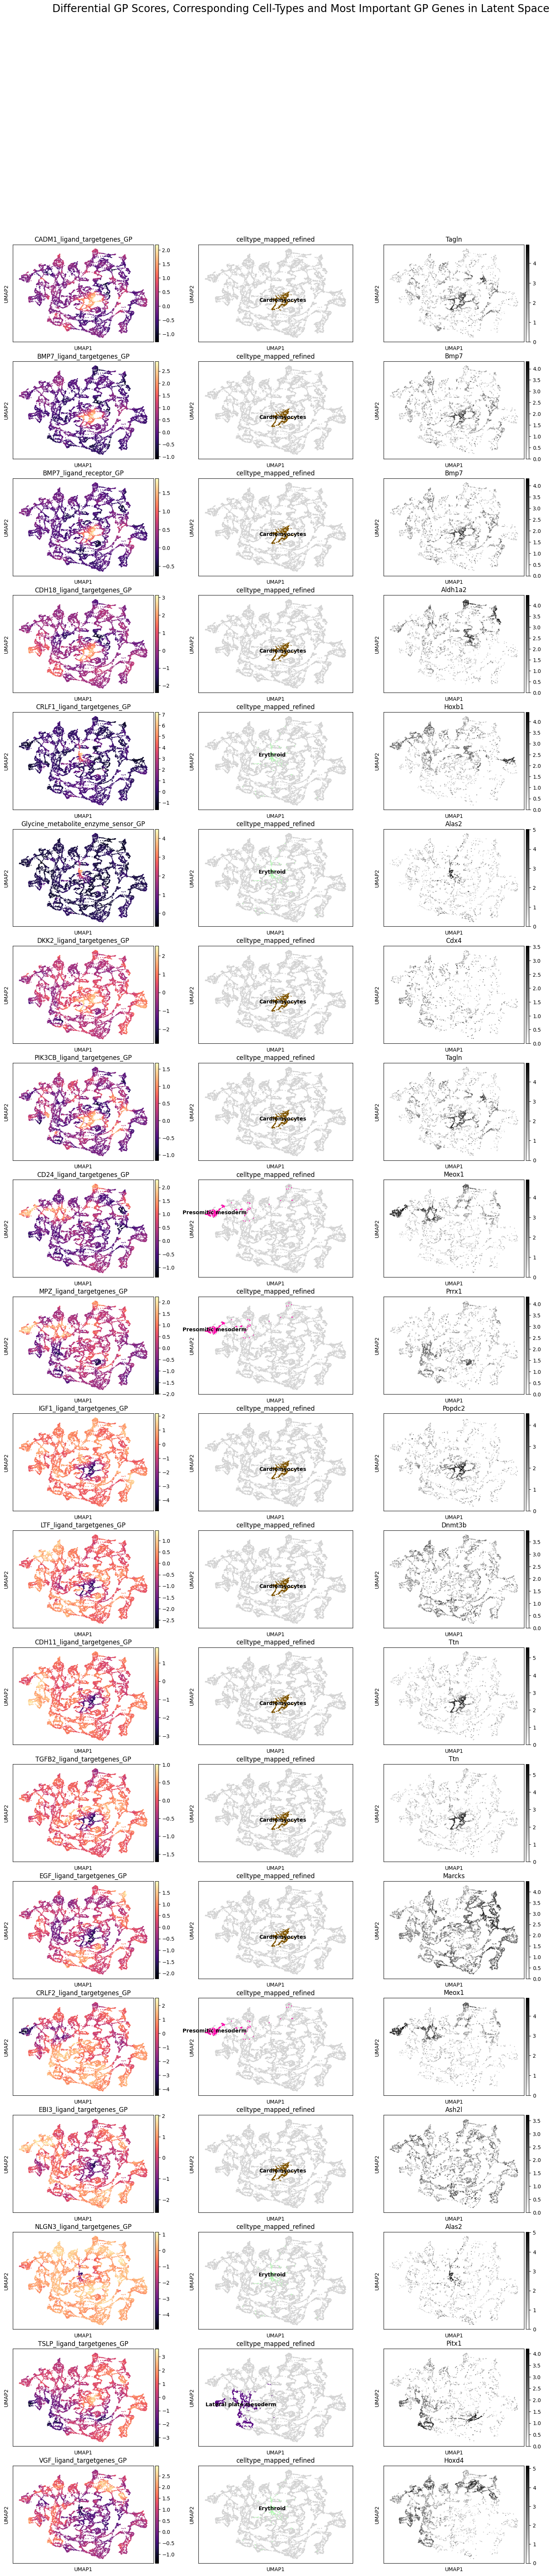

In [493]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_folder_path}/cell_type_gp_scores_cell_types_most_important_genes_all_categories.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 4.3.1.2 Explore All GPs Across Specific Categories

In [ ]:
selected_cats = ["Erythroid", "Cardiomyocytes"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_path}/differential_gp_scores_per_cell_type_specific_categories.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_path}/cell_type_gp_scores_cell_types_most_important_genes_specific_categories.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 4.3.1.3 Explore Specific GPs

In [ ]:
selected_gps = ["BMP7_ligand_targetgenes_GP", "EPOR_ligand_receptor_GP"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=selected_gps,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_path}/differential_gp_scores_per_cell_type_specific_gps.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_path}/cell_type_gp_scores_cell_types_most_important_genes_specific_gps.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

#### 4.3.2 Spatial GP Enrichments

Same analysis can be done with spatial cluster labels instead of cell-types.

#### 4.3.3 GP Gene Importances

In [ ]:
selected_gp = ["BMP7_ligand_targetgenes_GP"]

In [ ]:
gene_importances_df = model.compute_gp_gene_importances(
    selected_gp="BMP7_ligand_receptor_GP",
    adata=None)

display(gene_importances_df)

In [ ]:
genes = list(gene_importances_df["gene"])

for gene in genes:
    sc.pl.umap(model.adata,
               color=gene,
               color_map="binary",
               legend_loc="on data",
               na_in_legend=False)

## 5. Learn De-Novo CCI GPs

### 5.1 Initialize, Train & Save Model

In [ ]:
model = Autotalker.load(dir_path=f"{model_artifacts_path}/autotalker_combined_gps_{current_timestamp}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        n_addon_gps=10,
                        gp_names_key=gp_names_key,
                        freeze_non_addon_weights=True)

In [ ]:
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_l1_addon=lambda_l1_addon)

In [ ]:
model.save(dir_path=f"{model_artifacts_path}/autotalker_combined_denovo_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

Same analysis can be repeated with de-novo gene programs.